In [1]:
# Imports & setup
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


In [2]:
# Load data
filepath = "Life Expectancy Data.csv"
data = pd.read_csv(filepath)
print(data.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


In [3]:
# Select columns
selected_cols = ["Alcohol", "Adult Mortality", "Hepatitis B", "Measles ", " BMI ",
                 "Polio", "Total expenditure", "Diphtheria ", " HIV/AIDS",
                 "GDP", " thinness  1-19 years", "Schooling", "infant deaths", "Life expectancy ", "Status"]
selected_data = data[selected_cols]
column_names = ["Alcohol", "Adult Mortality", "Hepatitis B", "Measles", "BMI",
                         "Polio", "Total Expenditure", "Diphtheria", "HIV/AIDS",
                         "GDP", "Thinness 1-19 Years", "Schooling", "Infant Deaths", "Life Expectancy", "Status"]

selected_data.columns = column_names

In [4]:
# Transform selected columns
transformed_data = selected_data.apply({"Adult Mortality": np.sqrt,
                                     "Life Expectancy": lambda x: x,
                                     "Alcohol": np.sqrt,
                                     "Hepatitis B": lambda x: np.log(100 - x),
                                     "Measles": lambda x: np.log(x + 0.1),
                                     "BMI": lambda x: np.log(100 - x),
                                     "Polio": lambda x: np.log(100 - x),
                                     "Total Expenditure": lambda x: x,
                                     "Diphtheria": lambda x: np.log(100 - x),
                                     "HIV/AIDS": np.log,
                                     "GDP": np.log,
                                     "Thinness 1-19 Years": np.log,
                                     "Schooling": lambda x: x,
                                     "Status": lambda x: x,
                                     "Infant Deaths": lambda x: x})

In [5]:
# Remove rows with outliers
def find_outliers(data):
  q1 = np.nanpercentile(data, 25)
  q3 = np.nanpercentile(data, 75)
  iqr = q3 - q1
  min_threshold = q1 - 1.5*iqr
  max_threshold = q3 + 1.5*iqr
  return list( np.where((data < min_threshold) | (data > max_threshold))[0] )

def get_filtered_data(remove_status="Developed"):
    outliers = []
    for i, col in transformed_data.items():
      if i != "Status":
          outliers += find_outliers(col)
      else:
          outliers += list( np.where(data["Status"] == remove_status)[0] )
    
    
    data_no_outliers = transformed_data.drop(index=outliers).reset_index(drop=True).drop('Status', axis=1)
    # Replace missing values with mean
    imputer = SimpleImputer(strategy="mean")
    new_data = pd.DataFrame(imputer.fit_transform(data_no_outliers), columns=data_no_outliers.columns)

    train_data, test_data = train_test_split(new_data, train_size=0.8, random_state=1)
    train_data, val_data = train_test_split(train_data, train_size=0.8, random_state=1)

    return train_data, val_data, test_data

In [6]:

def search_for_best_model(train_data, val_data, test_data):
    vars = ["Alcohol", "Adult Mortality", "Hepatitis B", "Measles", "BMI",
                         "Polio", "Total Expenditure", "Diphtheria", "HIV/AIDS",
                         "GDP", "Thinness 1-19 Years", "Schooling", "Infant Deaths"]

    X_test = test_data[vars]
    y_test = test_data["Life Expectancy"]
    
    
    
    # Prepare training and validation sets
    X_train = train_data[vars]
    X_val = val_data[vars]
    y_train = train_data["Life Expectancy"]
    y_val = val_data["Life Expectancy"]
    
    # Dictionary to store the best MSE for each model size
    best_mse_per_size = {}
    best_model_per_size = {}
    
    # Loop through 1 to the total number of variables
    for k in range(1, len(vars) + 1):
        best_mse = np.inf
        best_combination = None
        
        # Generate all combinations of variables of size k
        for combination in combinations(vars, k):
            # Select the current subset of variables
            X_train_subset = X_train[list(combination)]
            X_val_subset = X_val[list(combination)]
            
            # Initialize and train the linear regression model
            model = LinearRegression()
            model.fit(X_train_subset, y_train)
            
            # Predict on the validation set
            y_pred = model.predict(X_val_subset)
            
            # Calculate the mean squared error on the validation set
            mse = mean_squared_error(y_val, y_pred)
            
            # Update the best model if the current one is better
            if mse < best_mse:
                best_mse = mse
                best_combination = combination
                best_model = model
        
        # Store the best mse and model for the current size
        best_mse_per_size[k] = best_mse
        best_model_per_size[k] = (best_combination, best_model)
    
        print(f"Best model for size {k} uses variables {best_combination} with MSE: {best_mse}")
    
    return best_model_per_size, best_mse_per_size

def visualize_models(best_mse_per_size):
        
    # Assuming 'best_mse_per_size' is filled with the MSE values from the previous steps
    sizes = list(best_mse_per_size.keys())
    mses = [best_mse_per_size[size] for size in sizes]
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, mses, marker='o', linestyle='-', color='b')
    plt.title('Developed Countries: MSE vs Num Features')
    plt.xlabel('Number of Variables')
    plt.ylabel('Best Mean Squared Error')
    plt.grid(True)
    plt.xticks(sizes)  # Ensure all x-values are shown
    plt.show()

Best model for size 1 uses variables ('Thinness 1-19 Years',) with MSE: 11.505728249462283
Best model for size 2 uses variables ('GDP', 'Thinness 1-19 Years') with MSE: 10.3950087759715
Best model for size 3 uses variables ('Adult Mortality', 'GDP', 'Thinness 1-19 Years') with MSE: 9.615331222496211
Best model for size 4 uses variables ('Adult Mortality', 'Measles', 'GDP', 'Thinness 1-19 Years') with MSE: 9.355271434948405
Best model for size 5 uses variables ('Adult Mortality', 'Measles', 'BMI', 'GDP', 'Thinness 1-19 Years') with MSE: 9.286880660072509
Best model for size 6 uses variables ('Adult Mortality', 'Measles', 'BMI', 'Polio', 'GDP', 'Thinness 1-19 Years') with MSE: 9.217443315662136
Best model for size 7 uses variables ('Adult Mortality', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'GDP', 'Thinness 1-19 Years') with MSE: 9.204092299677248
Best model for size 8 uses variables ('Adult Mortality', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'HIV/AIDS', 'GDP', 'Thinness 1-19 Years') 

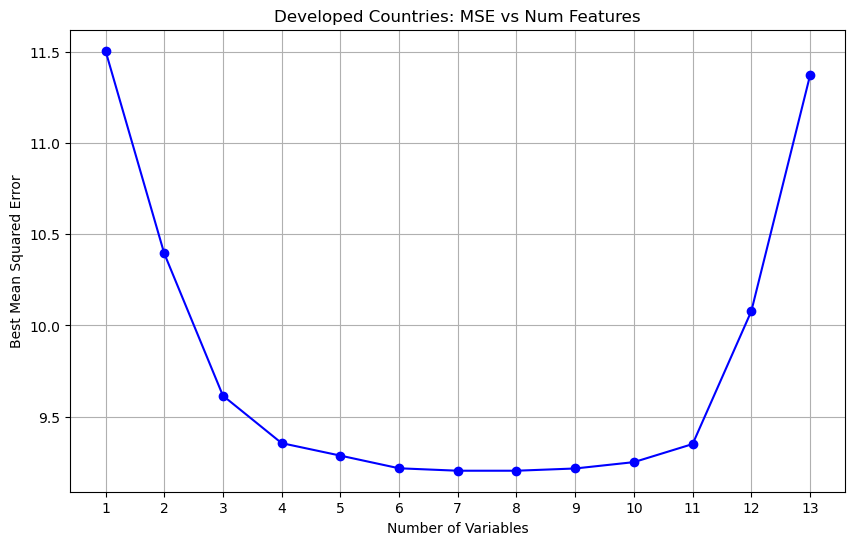

In [7]:
# Model for Developed Countries:

train_data, val_data, test_data = get_filtered_data(remove_status="Developing")
best_models, best_mse = search_for_best_model(train_data, val_data, test_data)
visualize_models(best_mse)


In [8]:

# Select model with 3 parameters
developed_model = best_models[3][1]
print("Coefficients:", developed_model.coef_)
print("Intercept:", developed_model.intercept_)

Coefficients: [-0.27095814  0.43675974 -2.91470659]
Intercept: 77.6985503697252


Best model for size 1 uses variables ('HIV/AIDS',) with MSE: 27.084651413799165
Best model for size 2 uses variables ('HIV/AIDS', 'Schooling') with MSE: 18.683103158546714
Best model for size 3 uses variables ('Adult Mortality', 'HIV/AIDS', 'Schooling') with MSE: 16.18348247119851
Best model for size 4 uses variables ('Adult Mortality', 'Measles', 'HIV/AIDS', 'Schooling') with MSE: 15.501134400057483
Best model for size 5 uses variables ('Adult Mortality', 'Diphtheria', 'HIV/AIDS', 'Thinness 1-19 Years', 'Schooling') with MSE: 14.876433715916676
Best model for size 6 uses variables ('Adult Mortality', 'Hepatitis B', 'Measles', 'Diphtheria', 'HIV/AIDS', 'Schooling') with MSE: 14.280538584725807
Best model for size 7 uses variables ('Adult Mortality', 'Hepatitis B', 'Measles', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Schooling') with MSE: 13.84508207659209
Best model for size 8 uses variables ('Adult Mortality', 'Hepatitis B', 'Measles', 'BMI', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Schooling') with

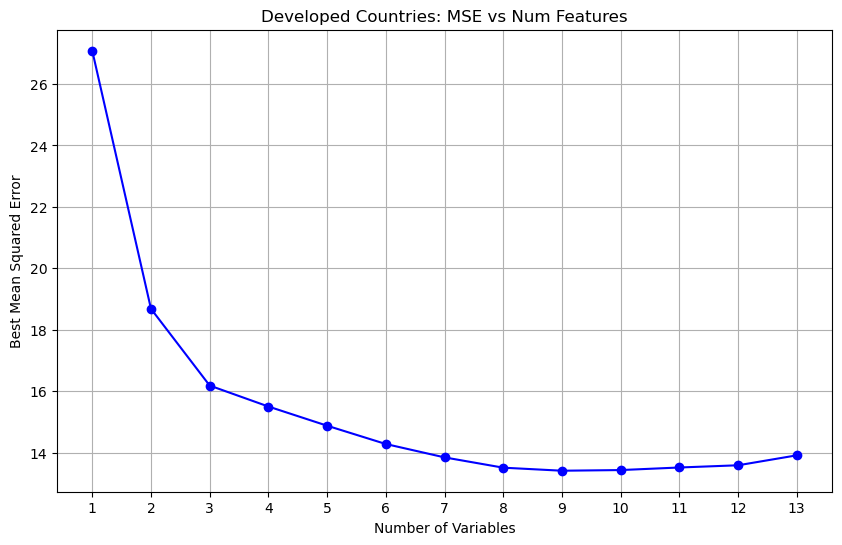

In [9]:
# Model for Developing Countries:

train_data, val_data, test_data = get_filtered_data(remove_status="Developed")
best_models, best_mse = search_for_best_model(train_data, val_data, test_data)
visualize_models(best_mse)


In [10]:

# Select model with 7 parameters
developed_model = best_models[7][1]
print("Coefficients:", developed_model.coef_)
print("Intercept:", developed_model.intercept_)

Coefficients: [-0.26419637  0.92913105 -0.16064211 -1.19604468 -2.33386761  0.46089274
  0.88222599]
Intercept: 56.337306479077085
